In [272]:
# LIBRERIAS

import os
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
import kerastuner as kt


tf.config.list_physical_devices('GPU') 



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [273]:
# Lectura de ficheros con los datasets de las empresas a analizar

companies = {}
ficheros = os.listdir('data')

for file in ficheros:
    company = file[:-4]
    dfcompany = pd.read_csv(f"data/{file}")
    companies[company] = dfcompany




In [274]:
# Tomamos datos de amazon para pruebas con el modelo.
dfcompany = companies['AMZN']
dfcompany

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AMZN,2017-04-24 00:00:00+00:00,907.41,909.990,903.8200,908.68,3118123,907.41,909.990,903.8200,908.68,3118123,0.0,1.0
1,AMZN,2017-04-25 00:00:00+00:00,907.62,909.480,903.0000,907.04,3367734,907.62,909.480,903.0000,907.04,3367734,0.0,1.0
2,AMZN,2017-04-26 00:00:00+00:00,909.29,915.749,907.5600,910.30,2562595,909.29,915.749,907.5600,910.30,2562595,0.0,1.0
3,AMZN,2017-04-27 00:00:00+00:00,918.38,921.860,912.1100,914.39,4255693,918.38,921.860,912.1100,914.39,4255693,0.0,1.0
4,AMZN,2017-04-28 00:00:00+00:00,924.99,949.590,924.3335,948.83,7278819,924.99,949.590,924.3335,948.83,7278819,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,AMZN,2022-04-14 00:00:00+00:00,3034.13,3117.940,3029.4350,3107.80,2579907,3034.13,3117.940,3029.4350,3107.80,2579907,0.0,1.0
1255,AMZN,2022-04-18 00:00:00+00:00,3055.70,3080.790,3005.0100,3030.47,2325676,3055.70,3080.790,3005.0100,3030.47,2325676,0.0,1.0
1256,AMZN,2022-04-19 00:00:00+00:00,3162.31,3172.980,3031.0100,3040.59,2746321,3162.31,3172.980,3031.0100,3040.59,2746321,0.0,1.0
1257,AMZN,2022-04-20 00:00:00+00:00,3079.96,3152.050,3072.0700,3152.05,2958600,3079.96,3152.050,3072.0700,3152.05,2958600,0.0,1.0


In [275]:
# Crreación de una matriz de datos de para la red neuronal
def create_dataset(dataset, look_back):
	x_data, y_data = [], []
	for i in range(len(dataset)-look_back-1):
		x = dataset[i:(i+look_back), 0]
		x_data.append(x)
		y = dataset[i + look_back, 0]
		y_data.append(y)
        
	return np.array(x_data), np.array(y_data)

def graficar(dfcompany, company):
	plt.plot(dfcompany)
	plt.xlabel('Days')
	plt.ylabel('Price')
	plt.title(label=company)

# Graficar el resultado
def graficarResultado(dfcompany, look_back, train_predict, test_predict):
    # Ajustamos los datos para mostrar la predicción
    trainPredictPlot = np.empty_like(dfcompany)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
    
    testPredictPlot = np.empty_like(dfcompany)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dfcompany)-1, :] = test_predict

    # Mostrar las los datos originales y la predicción
    plt.plot(scaler.inverse_transform(dfcompany), label='Original data')
    plt.plot(trainPredictPlot, label='Train prediction')
    plt.plot(testPredictPlot, label='Test prediction')
    plt.legend()
    
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()
	
#Separar datos de entrenamiento y test
def split(dfcompany, look_back, percent=70):
    training_size = int(len(dfcompany)*percent) 
    test_size = len(dfcompany)-training_size 

    train_data, test_data = dfcompany[0:training_size,:], dfcompany[training_size:len(dfcompany),:1]


    #Creamos la matrix para los datos de entrenamiento y test    
    X_train, y_train = create_dataset(train_data, look_back) #(,) (,)
    X_test, y_test = create_dataset(test_data, look_back) #(,) (,)
    #print(f"La matriz X_train tiene la forma: {X_train.shape}")
    #print(f"La matriz y_train tiene la forma: {y_train.shape}")
    #print(f"La matriz X_test tiene la forma: {X_test.shape}")
    #print(f"La matriz y_test tiene la forma: {y_test.shape}")
    

    # Hay que hacer reshape a las entradas de la red LSTM añadiendo 1 dimension [samples, look_back, features]
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


    return X_train, X_test, y_train, y_test



In [276]:
def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()

  # Tune the number of units in the first LSTM layer
  # Choose an optimal value between 10-100
  hp_units0 = hp.Int('units0', min_value=10, max_value=100, step=20)
  model.add(LSTM(units=hp_units0, input_shape=(look_back,1), return_sequences=True, name='LSTM1'))

  # Tune the number of units in the second LSTM layer
  # Choose an optimal value between 10-100
  hp_units1 = hp.Int('units1', min_value=10, max_value=100, step=20)
  model.add(LSTM(units=hp_units1, name='LSTM2'))
  
  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(Dense(1, activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mse'])

  return model

In [277]:
def prediccion (model, X_train, X_test, y_train, y_test, look_back):
    # Realizar predicción sobre datos de entranamiento y test
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Transformamos los datos a su escala original
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    return  train_predict, test_predict

In [278]:
dictErrores = {}

In [279]:
# Definimos cuantos días usará el modelo para predecir el día siguiente
look_back = 50

# Instanciamos el tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                    objective='val_loss', # objective to optimize
                    max_epochs=10,
                    factor=3, # the denominator of the number of models trained in every iteration of the training loop.
                    directory='keras_tuner_dir', # directory to save logs 
                    project_name='Stock_prediction')

# hypertuning settings
tuner.search_space_summary() 

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=5, min_delta=0.5)

INFO:tensorflow:Reloading Oracle from existing project keras_tuner_dir\Stock_prediction\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_dir\Stock_prediction\tuner0.json
Search space summary
Default search space size: 3
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [280]:
def generarHipermodelo(X_train, y_train, X_test, y_test): 


    # Perform hypertuning
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test,y_test), callbacks=[stop_early]) 

    best_hp = tuner.get_best_hyperparameters()[0]

    # Build the model with the optimal hyperparameters
    h_model = tuner.hypermodel.build(best_hp)
    #h_model.summary()
    #print(tuner.get_best_hyperparameters()[0].get('learning_rate'))

    return h_model




In [281]:
def generarResultados(dfcompany):
    #dfcompany = companies[company]
    # Por cada empresa, preprocesar, entrenar y guardar resultados
    company = dfcompany.iloc[0,0]

    # Descartamos todas las columnas y nos quedamos unicamente con el precio de cierre de la acción
    dfcompany = dfcompany.reset_index()['close']
    scaler=MinMaxScaler(feature_range=(0,1))
    dfcompany = scaler.fit_transform(np.array(dfcompany).reshape(-1,1))
    X_train, X_test, y_train, y_test = split(dfcompany, look_back, percent=0.90)

    h_model = generarHipermodelo(X_train, y_train, X_test, y_test)
    #Entrenamiento del modelo mejorado
    history = h_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[stop_early])

    train_predict, test_predict = prediccion(h_model, X_train, X_test, y_train, y_test, look_back)

    # Calculamos el error en entrenamiento y test
    train_error = math.sqrt(mean_squared_error(y_train, train_predict))
    test_error = math.sqrt(mean_squared_error(y_test, test_predict))

    print(f"Para la empresa {company}")
    print(f"Error entrenamiento: {train_error}")
    print(f"Error test: {test_error}")

    #graficarResultado(dfcompany, look_back, train_predict, test_predict)
    return test_error

In [282]:
for company in companies:
    #if company == 'AMZN':
    dfcompany = companies[company]
    dictErrores[company] = generarResultados(dfcompany)
    


INFO:tensorflow:Oracle triggered exit
Epoch 1/50
14/14 [==============================] - 4s 75ms/step - loss: 0.0444 - mse: 0.0444 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 2/50
14/14 [==============================] - 0s 15ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 3.2390e-04 - val_mse: 3.2390e-04
Epoch 3/50
14/14 [==============================] - 0s 16ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 3.5258e-04 - val_mse: 3.5258e-04
Epoch 4/50
14/14 [==============================] - 0s 15ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 3.7980e-04 - val_mse: 3.7980e-04
Epoch 5/50
14/14 [==============================] - 0s 15ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 3.7377e-04 - val_mse: 3.7377e-04
Epoch 6/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 4.4660e-04 - val_mse: 4.4660e-04
Para la empresa AAL
Error entrenamiento: 2290.7429527407894
Error test: 1404.311057742667
INFO:tensorflow:Oracle triggered exit
Epoch 1/

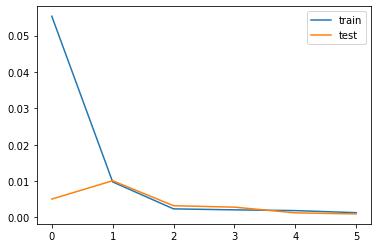

In [283]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [288]:
for company in dictErrores:
    print (company+ " " + str(dictErrores[company]))

AAL 1404.311057742667
AAPL 1285.8636423446276
ADBE 2547.766085543771
ADI 2931.8216314932515
ADP 3034.724933929358
ADSK 2454.7674304002257
AKAM 3190.511566981818
ALXN 3190.303506080724
AMAT 3200.08800039345
AMGN 3033.2205086462877
AMZN 3280.8476797468848
ATVI 2584.3675181450344
AVGO 3509.9132715939086
BBBY 1731.932166437578
BIDU 1630.1675305207493
BIIB 1290.8697655990204
BMRN 1789.4795234478377
CERN 3532.7344217093632
CHKP 2951.307742890875
CHTR 2571.274838577067
CMCSA 2423.8741961134
COST 3222.2087529136556
CSCO 3053.0286775965455
CSX 1151.4014549612957
CTRP 1449.3764272279968
CTSH 3303.3408108209865
CTXS 1682.5893014695835
DISCK 1527.5985591061026
DISH 1676.3733380900362
DLTR 2765.903967102093
EA 2970.067181136391
EXPE 3106.1696469041335
FAST 2691.8790556942376
FB 2449.90414346311
FISV 1967.32627859988
GILD 1636.1392772090983
GOOGL 3306.41984248245
HSIC 1653.700837104649
ILMN 2325.202544741923
INCY 1475.550996265572
INTC 2228.262033897327
INTU 2808.4052234463475
ISRG 1186.954249048977

In [304]:
errors = np.array(list(dictErrores.items()))

errors = errors[:,1].astype(float)
#print(errors)
print (f"La media del RMSE obtenido en test entrenando cada empresa por separado es {np.mean(errors)}")

La media del RMSE obtenido en test entrenando cada empresa por separado es 2448.906327757688
